#### Raquel Peña.
#### Student number: 23083963

In [ ]:
import numpy as np
import scipy as sp
from scipy import io
import cv2 as cv 
import matplotlib.pyplot as plt
import pylab
import os # for reading all files in a folder
pylab.rcParams['figure.figsize'] = (12.0, 10.0)

# Part H: Tracking and Homographies

In this part we use Practical 7c to track the positions of the four corners of the square and project a cube into the images. 

TO DO: QUESTIONS TO THINK ABOUT...

- Do the results look realistic? 
- If not then what factors do you think might be causing this


TO DO: your routines for computing a homography and extracting a valid rotation and translation go in the code below. Tips:
- you may define functions for T and H matrices respectively.
- you may need to turn the points into homogeneous form before any other computation. 
- you may need to solve a linear system in Ah = 0 form. Write your own routines or using the builtin function 'svd'. 
- you may apply the direct linear transform (DLT) algorithm to recover the best homography H.
- you may explain what & why you did in the report.


In [2]:
# TO DO: Copy and paste the function HW2_Practical7c in here. 

In [3]:
#Likelihood function is simple patch similarity

def computeLikelihood(image, template):
    #opencv's available methods - experiment with these
    #careful what range the output is!
    methods = [cv.TM_CCOEFF, cv.TM_CCOEFF_NORMED, cv.TM_CCORR,
            cv.TM_CCORR_NORMED, cv.TM_SQDIFF, cv.TM_SQDIFF_NORMED]
    
    likelihood = cv.matchTemplate(image[:,:,2], template, methods[0])
    # (You can also try converting the image to greyscale instead of using the third channel as above with 
    #gray_image = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
    #likelihood = cv.matchTemplate(gray_image, template, methods[0])

    
    #we can pad to make this the size of the input image (for easier indexing)   
    pad_first = int(template.shape[0])
    pad_second = int(template.shape[1])
    pad_amounts = ((0, pad_first-1), (0, pad_second-1))
    likelihood = np.pad(likelihood, pad_amounts, 'constant')
    likelihood[likelihood<0] = 0 # to avoid negative weights 
    
    # apply a 10x10 averaging filter for stability. You can experiment with different sizes. 
    kernel = np.ones((10,10),np.float32)/100
    smoothed = cv.filter2D(likelihood,-1,kernel) 
    return smoothed 

In [4]:
std_dev = 10  # Std noise 

def HW2_Practical7c(corner):
    template = sp.io.loadmat(corner+'.mat')['pixelsTemplate']
    #let's show the template
    print('We are matching this template with shape: ', template.shape)
    #plt.imshow(template)
    #plt.show()

    # Load all images in folder
    images = []
    iFrame = 0
    folder = 'Pattern01/'
    lst = os.listdir(folder)
    lst.sort()

    for frameNum in lst:
        images.append(cv.imread(folder+frameNum))
        iFrame += 1
    # plot first image 
    #plt.imshow(images[0])
    #plt.show()

    imgHeight, imgWidth, colors = images[0].shape
    numParticles = 2000;
    weight_of_samples = np.ones((numParticles,1))

    # TO DO: normalize the weights (may be trivial this time) [done]
    #weight_of_samples = weight_of_samples #replace this 
    weight_of_samples = weight_of_samples / np.sum(weight_of_samples)

    # Initialize which samples from "last time" we want to propagate: all of
    # them!:
    samples_to_propagate = range(0, numParticles)


    # ============================
    # NOT A TO DO: You don't need to change the code below, but eventually you may
    # want to vary the number of Dims (compare for example to lab 9b) 
    numDims_w = 2;
    # Here we randomly initialize some particles throughout the space of w:
    particles_old = np.random.rand(numParticles, numDims_w)
    particles_old[:,0] = particles_old[:,0] * imgHeight
    particles_old[:,1] = particles_old[:,1] * imgWidth
    # ============================

    #Initialize a temporary array r to store the per-frame MAP estimate of w. This is what we'll return in the end.
    r = np.zeros((iFrame, numDims_w));

    for iTime in range(iFrame):
        print('Processing Frame', iTime)
        # TO DO: compute the cumulative sume of the weights. [done]
        #cum_hist_of_weights = np.linspace(0, 1, numParticles) # replace this
        cum_hist_of_weights = np.cumsum(weight_of_samples)
        #print(weight_of_samples)


        # ==============================================================
        # Resample the old distribution at time t-1, and select samples, favoring
        # those that had a higher posterior probability.
        # ==============================================================
        samples_to_propagate = np.zeros(numParticles, dtype=np.int32)

        # Pick random thresholds in the cumulative probability's range [0,1]:
        some_threshes = np.random.rand(numParticles)


        # For each random threshold, find which sample in the ordered set is
        # the first one to push the cumulative probability above that
        # threshold, e.g. if the cumulative histogram goes from 0.23 to 0.26
        # between the 17th and 18th samples in the old distribution, and the
        # threshold is 0.234, then we'll want to propagate the 18th sample's w
        # (i.e. particle #18).

        for sampNum in range(numParticles): 
            thresh = some_threshes[sampNum]
            for index in range (numParticles):
                if cum_hist_of_weights[index] > thresh:
                    break
            samples_to_propagate[sampNum] = index

        # Note: it's ok if some of the old particles get picked repeatedly, while
        # others don't get picked at all.


        # =================================================
        # Visualize if you want
        # =================================================
        #plt.title('Cumulative histogram of probabilities for sorted list of particles')
        #plt.plot(np.zeros(numParticles), some_threshes,'b.')
        #plt.plot(range(0, numParticles), cum_hist_of_weights, 'rx-')
        #which_sample_ids = np.unique(samples_to_propagate)
        #how_many_of_each = np.bincount(np.ravel(samples_to_propagate))
        #for k in range(len(which_sample_ids)):
        #    plt.plot(which_sample_ids[k], 0, 'bo-', markersize = 3 * how_many_of_each[k], markerfacecolor='white')
        #plt.xlabel('Indeces of all available samples, with larger blue circles for frequently re-sampled particles\n(Iteration %01d)' % iTime)
        #plt.ylabel('Cumulative probability');
        #plt.show()
        # =================================================
        # =================================================

        # Predict where the particles we sampled from the old distribution of 
        # state-space will go in the next time-step. This means we have to apply 
        # the motion model to each old sample.
        particles_new = np.zeros_like(particles_old)
        for particleNum in range(numParticles):
            # TO DO: Incorporate some noise, e.g. Gaussian noise with std 20,
            # into the current location (particles_old), to give a Brownian
            # motion model.
            #particles_new[particleNum, :] =  particles_old[particleNum, :] # replace this
            noise = np.random.normal(0, std_dev, numDims_w)  # Noise for each w dimension
            particles_new[particleNum, :] = particles_old[samples_to_propagate[particleNum]] + noise  

 
            
        # TO DO: Not initially, but change the motion model above to have
        # different degrees of freedom, and optionally completely different
        # motion models. See Extra Credit for more instructions.

        #calculate likelihood function
        likelihood = computeLikelihood(images[iTime], template)

        #plot results
        #f, axarr = plt.subplots(1, 2)
        #axarr[0].imshow(images[iTime])
        #axarr[0].set_title('Particles')
        # now draw the particles onto the image
        #axarr[0].plot(particles_new[:,1]+template.shape[1]/2, particles_new[:,0]+template.shape[0]/2, 'rx')

        #plot the likelihood
        #axarr[1].imshow(likelihood)
        #axarr[1].set_title('Likelihood')



        # From here we incorporate the data for the new state (time t):
        # The new particles accompanying predicted locations in state-space
        # for time t, are missing their weights: how well does each particle
        # explain the observations x_t?
        for particleNum in range(numParticles):

            # Convert the particle from state-space w to measurement-space x:
            # Note: that step is trivial here since both are in 2D space of image
            # coordinates

            # Within the loop, we evaluate the likelihood of each particle:
            particle = particles_new[particleNum, :]
            # Check that the predicted location is a place we can really evaluate
            # the likelihood.
            inFrame = particle[0] >= 0.0 and  particle[0] <= imgHeight and particle[1] >= 0.0 and particle[1] <= imgWidth
            if inFrame:
                minX = particle[1]
                minY = particle[0]

                weight_of_samples[particleNum] = likelihood[int(minY), int(minX)]

            else:
                weight_of_samples[particleNum] = 0.0

        # TO DO: normalize the weights [done]
        #weight_of_samples = weight_of_samples # replace this
        weight_of_samples = weight_of_samples / np.sum(weight_of_samples)

        # find the location of the particle with highest weight
        indices = np.argsort(weight_of_samples,0)
        bestScoringParticles = particles_new[np.squeeze(indices[-15:]), :]
        #plt.plot(bestScoringParticles[-1:,1], bestScoringParticles[-1:,0], 'rx')
        # Return the MAP of middle position. Add template.shape/2 because matchTemplate finds the position of the upper left corner 
        # of the template. We want to plot the centre of the template. 
        r[iTime,:] = bestScoringParticles[-1,1]+template.shape[1]/2,bestScoringParticles[-1,0]+template.shape[0]/2
        print(r[iTime,:])   
        #plt.show()

        #print the original image and the position of the tracked corner.
        #plt.imshow(images[iTime])
        #plt.plot(r[iTime,0],r[iTime,1],'rx')
        #plt.show()
        # Now we're done updating the state for time t. 
        # For Condensation, just clean up and prepare for the next round of 
        # predictions and measurements:
        particles_old = particles_new

    return r

In [5]:
# instead of running the code here, you can also save the output of each function in a numpy array in HW2_Practical7c 
# and load it here. This could be handy if you need different hyperparameters for each corner.

LLs = HW2_Practical7c( 'll' )
LRs = HW2_Practical7c( 'lr' )
ULs = HW2_Practical7c( 'ul' )
URs = HW2_Practical7c( 'ur' )

We are matching this template with shape:  (25, 28)
Processing Frame 0
[196.81522273 401.52415789]
Processing Frame 1
[199.86899119 400.41182268]
Processing Frame 2
[202.9428299  401.85627423]
Processing Frame 3
[204.24482331 402.72303822]
Processing Frame 4
[204.59863077 403.21108084]
Processing Frame 5
[204.77784159 402.06140851]
Processing Frame 6
[206.76945732 400.72059481]
Processing Frame 7
[210.32990794 400.69696337]
Processing Frame 8
[210.50969635 401.50647016]
Processing Frame 9
[212.49016393 400.6867651 ]
Processing Frame 10
[211.02747453 403.87034524]
Processing Frame 11
[209.39350126 403.47880216]
Processing Frame 12
[210.84243674 404.35628339]
Processing Frame 13
[212.26281561 396.7817476 ]
Processing Frame 14
[218.26917513 390.27722932]
Processing Frame 15
[222.40135905 385.02426558]
Processing Frame 16
[225.90643704 383.92173835]
Processing Frame 17
[227.23258881 385.40691941]
Processing Frame 18
[232.9330157  382.58896127]
Processing Frame 19
[235.81884703 384.1683663 

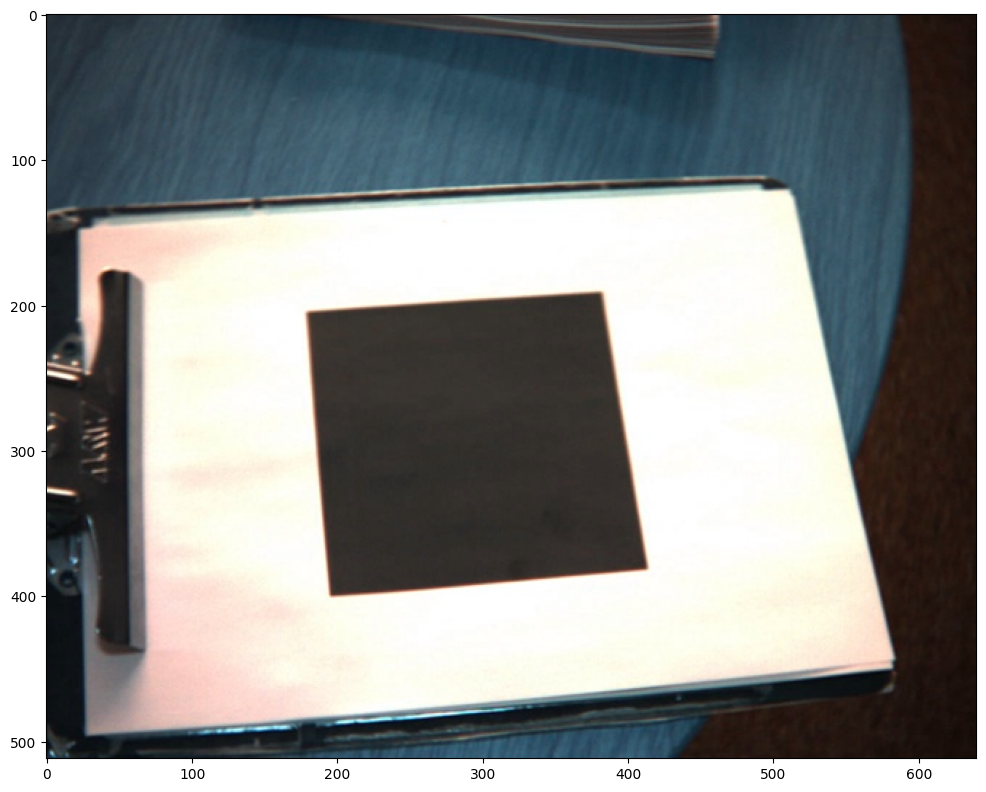

In [6]:
# Load all images in folder
images = []
nFrame = 0
folder = 'Pattern01/'
lst = os.listdir(folder)
lst.sort()

for frameNum in lst:
    images.append(cv.imread(folder+frameNum))
    nFrame += 1
# plot first image 
plt.imshow(images[0])
plt.show()


# Coordinates of the known target object (a dark square on a plane) in 3D:
XCart = np.array([[-50, -50,  50,  50],
          [50, -50, -50,  50],
            [0, 0, 0, 0]])

# These are some approximate intrinsics for this footage.
K = np.array([[640, 0, 320],
          [0, 512, 256],
            [0, 0, 1]])

# Define 3D points of wireframe object.
XWireFrameCart = np.array([[-50, -50,  50,  50, -50, -50,  50,  50],
          [50, -50, -50,  50, 50, -50, -50,  50],
            [0, 0, 0, 0, -100, -100, -100, -100, ]])

In [7]:
print(nFrame)

151


In [8]:
def solveAXEqualsZero(A):
    # TO DO: Write this routine - it should solve Ah = 0. You can do this using SVD. Consult your notes! 
    # Hint: SVD will be involved. 
  
    # Perform the Singular Value Decomposition (SVD) of A
    U, S, VT = np.linalg.svd(A)
    
    # The last vector of VT (the last row of V, transposed) is the solution to Ah = 0
    # This is because it corresponds to the smallest singular value, which should be zero or close to zero
    h = VT[-1]
    
    return h

In [9]:
def calcBestHomography(pts1Cart, pts2Cart):
    
    # This function should apply the direct linear transform (DLT) algorithm to calculate the best 
    # homography that maps the cartesian points in pts1Cart to their corresonding matching cartesian poitns 
    # in pts2Cart.
    pts1Hom = np.vstack((pts1Cart, np.ones((1, pts1Cart.shape[1]))))
    pts2Hom = np.vstack((pts2Cart, np.ones((1, pts2Cart.shape[1]))))
   
    # This function calls solveAXEqualsZero. Make sure you are wary of how to reshape h into a 3 by 3 matrix. 

    n_points = pts1Cart.shape[1]
    
    # TO DO: replace this:
    #H = np.identity(3)

    # TO DO: 
    # First convert points into homogeneous representation
    # Hint: we've done this before  in the skeleton code we provide.
    
    # Then construct the matrix A, size (n_points * 2, 9)
    # Consult the notes!
    A = []
    for i in range(n_points):
        X, Y, W = pts1Hom[:, i]
        u, v, w = pts2Hom[:, i]
        A.append([-X, -Y, -W,  0,  0,  0, u*X, u*Y, u*W])
        A.append([ 0,  0,  0, -X, -Y, -W, v*X, v*Y, v*W])
    
    # Solve Ah = 0 using solveAXEqualsZero and get h.
    A = np.array(A)  # Convert A to a numpy array
    h = solveAXEqualsZero(A)

    # Reshape h into the matrix H, values of h go first into rows of H
    H = h.reshape((3, 3))
    
    return H

In [10]:
def estimatePlanePose(XImCart,XCart,K):
    #K = intrinsic
    #XImCart = Image space
    # The goal of this function is to estimate the pose of a plane relative to camera (extrinsic matrix)
    # given points in image space xImCart, points in 3D world space XCart, and an intrinsics matrix K.
    
    # TO DO: replace this
    T = []

    #TO DO: Convert Cartesian image points XImCart to homogeneous representation XImHom
    XImHom = np.concatenate((XImCart, np.ones((1,XImCart.shape[1]))), axis=0)
    
    #TO DO: Convert image co-ordinates XImHom to normalized camera coordinates XCamHom    
    K_inv = np.linalg.inv(K)
    XCamHom = K_inv @ XImHom


    # TO DO: Estimate homography H mapping homogeneous (x,y) coordinates of positions
    # in real world to XCamHom (convert XCamHom to Cartesian, calculate the homography) -
    # use the routine you wrote for Practical 1B
    XCamCart  = XCamHom[0:2,:] / np.tile([XCamHom[2,:]],(2,1))
    H = calcBestHomography(XCart[:2, :], XCamCart)
    
    # TO DO: Estimate first two columns of rotation matrix R from the first two
    # columns of H using the SVD. NOTE: You do not need to transpose v from linalg.svd 
    R = np.zeros((3,3))  
    L_ = np.array([[1,0],
                   [0,1],
                   [0,0]])
    U, L, Vt = np.linalg.svd(H[:,:2])
    R[:, :2] = U @ L_ @ Vt


    # TO DO: Estimate the third column of the rotation matrix by taking the cross
    # product of the first two columns
    R[:,2] = np.cross(R[:,0], R[:,1])
  
    # TO DO: Check that the determinant of the rotation matrix is positive - if
    # not then multiply last column by -1.
    if np.linalg.det(R) < 0:
        R[:,-1] *= -1

    
    # TO DO: Estimate the translation t by finding the appropriate scaling factor k
    # and applying it to the third colulmn of H
    k = np.mean(H[:, :2] / R[:, :2]) 
    t = H[:, 2] / k 
    
    # TO DO: Check whether t_z is negative - if it is then multiply t by -1 and
    # the first two columns of R by -1.
    if t[2] <0:
        t += -1
        R[:, 0:2] *= -1 
            
    # TO DO: Assemble transformation into matrix form
    T = np.zeros((4,4))
    T[:3, :3] = R
    T[:3, 3] = t
    T[3,3] = 1

    
    return T

In [11]:
def projectiveCamera(K,T,XCart):
    ##TODO
    # The goal of this function is to project points in XCart through projective camera
    # defined by intrinsic matrix K and extrinsic matrix T. In essence, this function takes a set of points 
    # in 3D world space, XCart, and projects them into camera image space by applying the extrinsic matrix T 
    # and then applying the intrinsic matrix K.
    # 
    # There are three steps.
    # 1) Move from world space to camera space. 
    #            camera space points = extrinsics T * world space points 
    #
    # 2) Applying the intrinsics matrix to the camera space points after normalizing
    #           homogeneous image space points = K * normalized camera space points
    # 
    # 3) Move to image space cartesian points from image space homogeneous points, involves a 
    # normalization using the third row.
    
    
    # TO DO: Replace this
   # XImCart = []

    # TO DO: Convert Cartesian 3d points XCart to homogeneous coordinates XHom
    ones = np.ones((1, XCart.shape[1]))
    XHom = np.vstack((XCart, ones))  # Stacking the ones row under the XCart matrix
    
    # TO DO: Apply extrinsic matrix to XHom, to move to frame of reference of camera
    # Multiplying the extrinsic matrix T with the homogeneous coordinates XHom
    # to move to the camera's frame of reference
    XCamHom = np.dot(T, XHom)

    # TO DO: Project points into normalized camera coordinates xCamHom (remove 4th row)
    # Normalizing the camera coordinates by dividing by the fourth row (the scale factor)
    # This effectively removes the fourth dimension, simplifying from projective to camera space
    XCamNorm = XCamHom[:-1] / XCamHom[2]

    # TO DO: Move points to image coordinates xImHom by applying intrinsic matrix
    # Applying the intrinsic matrix K to the normalized camera coordinates
    # to get the points in image space
    XImHom = np.dot(K, XCamNorm)
    
    # TO DO: Convert points back to Cartesian coordinates xImCart
    # Normalizing the image space points by dividing by the third row to
    # convert from homogeneous to Cartesian coordinates
    # The result is a 2xN matrix of image space points
    XImCart = XImHom[:-1] / XImHom[2]
        
    return XImCart

Procesando frame 0
Procesando frame 1
Procesando frame 2
Procesando frame 3
Procesando frame 4
Procesando frame 5
Procesando frame 6
Procesando frame 7
Procesando frame 8
Procesando frame 9
Procesando frame 10
Procesando frame 11
Procesando frame 12
Procesando frame 13
Procesando frame 14
Procesando frame 15
Procesando frame 16
Procesando frame 17
Procesando frame 18
Procesando frame 19
Procesando frame 20
Procesando frame 21
Procesando frame 22
Procesando frame 23
Procesando frame 24
Procesando frame 25
Procesando frame 26
Procesando frame 27
Procesando frame 28
Procesando frame 29
Procesando frame 30
Procesando frame 31
Procesando frame 32
Procesando frame 33
Procesando frame 34
Procesando frame 35
Procesando frame 36
Procesando frame 37
Procesando frame 38
Procesando frame 39
Procesando frame 40
Procesando frame 41
Procesando frame 42
Procesando frame 43
Procesando frame 44
Procesando frame 45
Procesando frame 46
Procesando frame 47
Procesando frame 48
Procesando frame 49
Procesando

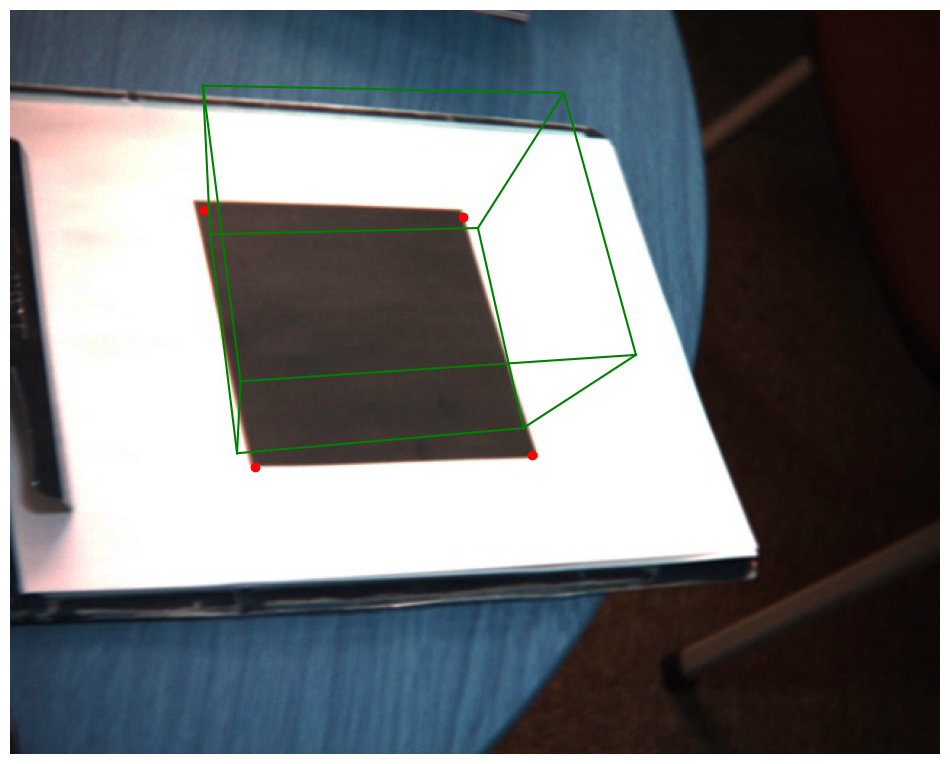

In [18]:
# Store data for the last frame
last_frame_data = None

for iFrame in range(nFrame):
    # Process each frame
    print(f"Processing frame {iFrame}") 
    xImCart = np.array([LLs[iFrame,:].T, ULs[iFrame,:].T, URs[iFrame,:].T, LRs[iFrame,:].T]).T

    # Get the current frame from the footage
    im = images[iFrame]

    # Calculate the extrinsic matrix T that relates the plane's position to the camera's position
    T = estimatePlanePose(xImCart, XCart, K)

    # Project the vertices of the 3D cube through the projective camera
    XWireFrameCartProjected = projectiveCamera(K, T, XWireFrameCart)

    # If it is the last frame, store the necessary information
    if iFrame == nFrame - 1:
        last_frame_data = (im, xImCart, XWireFrameCartProjected)

# Outside the loop, draw the data for the last frame
if last_frame_data:
    im, xImCart, XWireFrameCartProjected = last_frame_data
    
    plt.imshow(im)
    plt.scatter(x = xImCart[0,:], y = xImCart[1,:], color = 'r')

    # Draw the edges of the cube
    edges = [
        (0, 1), (1, 2), (2, 3), (3, 0),  # Edges of the front face
        (4, 5), (5, 6), (6, 7), (7, 4),  # Edges of the back face
        (0, 4), (1, 5), (2, 6), (3, 7)   # Edges connecting the front and back faces
    ]

    for edge in edges:
        plt.plot(
            [XWireFrameCartProjected[0, edge[0]], XWireFrameCartProjected[0, edge[1]]],
            [XWireFrameCartProjected[1, edge[0]], XWireFrameCartProjected[1, edge[1]]],
            'g-'
        )

    plt.axis('off')
    plt.show()

** Note: The final stage is showed.

The **development** of this practice focuses on object tracking and estimating homographies to project a 3D cube onto an image. The approach involved tracking the position of the four corners of a square using a particle filter based on the similarity between a template and the current image. Subsequently, the best homography that maps Cartesian points in one image to their corresponding points in another is estimated. After this, the extrinsic matrix, which is the pose of the plane relative to the camera, is determined using two measurements: rotation and translation. Finally, the corners of a 3D cube are projected through the camera defined by the intrinsic and extrinsic matrices to determine their location in the image space.

The projected 3D cube, outlined in green, does not perfectly align with the reference red markers. This visual discrepancy could be attributed to initial estimation errors, but the impact of blurred images found in a significant portion of the 150 image set must also be considered, the blurriness becomes more pronounced after a certain number of images, highlighting the potential for improvement in image selection, as well as camera calibration.

Additionally, a problem with the alignment of the reference black square has been identified; its slight tilt seems to be affecting the projection's accuracy. This tilt suggests a need to refine the rotation estimation to correct the apparent distortion, which causes one of the cube's planes to appear visually larger than the others. With these considerations, a more proportional representation of the object in three-dimensional space could be achieved.